## Import libraries

In [3]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob

# global variables
OUTPUT_FOLDER = "./output_images/"
TEST_FOLDER = "./test_images/"


## Explore dataset

There are  8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32


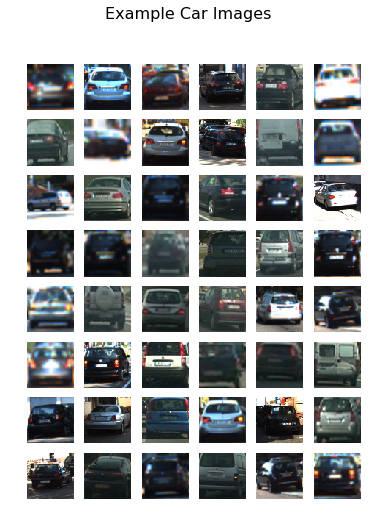

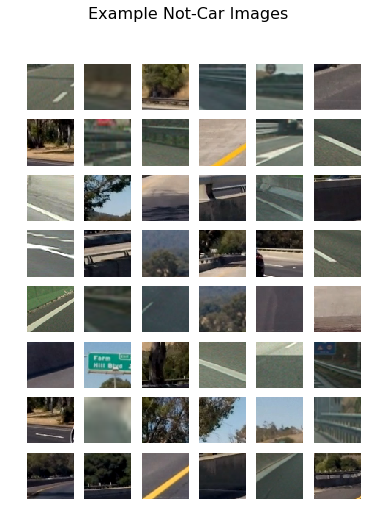

In [4]:
images = glob.glob('*.jpeg')
cars = []
notcars = []

# Divide up into cars and notcars
images = glob.glob('./non-vehicles/*/*.png')
cars = []
notcars = []
for image in images:
        notcars.append(image)
images = glob.glob('./vehicles/*/*.png')
for image in images:
        cars.append(image)

# Helper function to plot graphs and figures
def plot_figures(figures, figSize, r = 1, c=1, fig_title=None, labels=None):
    fig, axs = plt.subplots(ncols=c, nrows=r, figsize=figSize)
    axs = axs.ravel()
    for index, title in zip(range(len(figures)), figures):
        axs[index].imshow(figures[title], plt.gray())
        if(labels != None):
            axs[index].set_title(labels[index])
        axs[index].set_axis_off()
    if labels is not None: plt.tight_layout()
    if fig_title is not None:
        fig.suptitle(fig_title, fontsize=16)

# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    test_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = test_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = test_img.dtype
    # Return data_dict
    return data_dict
    
data_info = data_look(cars, notcars)

print('There are ', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

# Display 48 randomly chosen car images from the dataset
labels = []
car_images = {}
for i in range(0, 48):
    idx = np.random.randint(0, len(cars))
    car_images[i] = mpimg.imread(cars[idx])
    labels.append(cars[idx])
plot_figures(car_images, (6,8), 8, 6, "Example Car Images", None)
plt.savefig(OUTPUT_FOLDER + "car_visualization.png")

# Display 48 randomly chosen noncar images from the dataset
labels = []
notcar_images = {}
for i in range(0, 48):
    idx = np.random.randint(0, len(notcars))
    notcar_images[i] = mpimg.imread(notcars[idx])
    labels.append(notcars[idx])
plot_figures(notcar_images, (6,8), 8, 6, "Example Not-Car Images", None)
plt.savefig(OUTPUT_FOLDER + "notcar_visualization.png")


## Data augmentation

False positives are coming from dimly light parts of the road, especially the guardrail. We have to augment the training set with images adjusted with a lower brightness

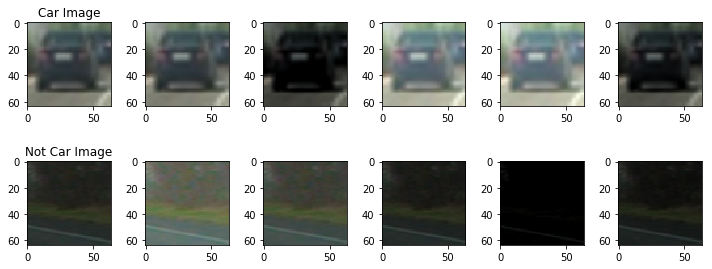

In [6]:
# image is a RGB image
# outputs a saturated RGB image that has been lowered in brightness by a random value
def adjust_brightness(img, range=(-80,80)):
    image = np.copy(img)
    if (img.dtype == 'float32' or img.dtype == 'float64'):
        image = (image * 255).astype(np.uint8)
    v = np.random.randint(range[0], range[1])
    image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    image[:,:,2] = cv2.add(image[:,:,2], v)
    
    return (cv2.cvtColor(image, cv2.COLOR_HSV2RGB)).astype(np.float32) / 255

images = glob.glob('./non-vehicles/*/image3689.png')
cars = []
notcars = []
for image in images[0:1]:
    notcars.append(image)
images = glob.glob('./vehicles/*/*.png')
for image in images[0:1]:
    cars.append(image)

NUM_AUGMENTATION = 5
for car, notcar in zip(cars, notcars):
    car_image = mpimg.imread(car)
    notcar_image = mpimg.imread(notcar)
    fig, axes = plt.subplots(2, NUM_AUGMENTATION +1, figsize=(2*NUM_AUGMENTATION, 2*2))
    axes[0,0].imshow(car_image)
    axes[0,0].set_title("Car Image")
    axes[1,0].imshow(notcar_image)
    axes[1,0].set_title("Not Car Image")
    for i in range(1, NUM_AUGMENTATION+1):
        augmented_car = adjust_brightness(car_image)
        augmented_notcar = adjust_brightness(notcar_image)
        axes[0, i].imshow(augmented_car)
        axes[1, i].imshow(augmented_notcar)
    fig.tight_layout()
    fig.savefig(OUTPUT_FOLDER + "augment_brightness_comparision.png")

## Preprocessing

I noticed that the SVM does poorly on patches of images that are dimly lit (in shadows etc.), hence we use histogram equalization on the images before feature extraction. Here is a visualization of the results. We can see that histogram equalization is able to bring out the features in an image - the colors, edges, gradient and shape. Note that although traditionally histogram equalization is only to be used on grayscale image, here we treat each channel of a colorspace as a separate historgram to be equalized.


In [7]:
# input image must be a single channel image
def equalize_hist(img):
    if img.dtype == 'float32' or img.dtype == 'float64':
        img = (img * 255).astype(np.uint8)
    img = np.reshape(img, (img.shape[0], img.shape[1]))
    return (cv2.equalizeHist(img)).astype(np.float32) / 255

## Extract features

In [8]:
# Define a function to extract features from a list of images
# This will extract color_histograms and hog features
def extract_features(imgs, hist_colorspace='RGB', cspace='RGB', spatial_size=(32, 32),
                     hist_bins=32, hist_range=(0, 256), orient=9, 
                     pix_per_cell=8, cell_per_block=2, hog_channel=0, augmentation_factor=5):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        for i in range(0, augmentation_factor):
            if i != 0: image = adjust_brightness(image)
            image[:,:,0] = equalize_hist(image[:,:,0])
            image[:,:,1] = equalize_hist(image[:,:,1])
            image[:,:,2] = equalize_hist(image[:,:,2])
            
            # Apply bin_spatial() to get spatial color features
            spatial_features = bin_spatial(image, size=spatial_size)
            # Apply color_hist() also with a color space option
            _, _, _, _, hist_features = color_hist(image, cspace=hist_colorspace, nbins=hist_bins, bins_range=hist_range)
            
            # apply color conversion for hog features
            feature_image = convert_color(image, cspace)
            
            # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    feature_image_equalized = equalize_hist(feature_image[:,:,channel])
                    # feature_image_equalized = feature_image[:,:,channel]
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                feature_image_equalized = equalize_hist(feature_image[:,:,hog_channel])
                # feature_image_equalized = feature_image[:,:,hog_channel]
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            features.append(np.concatenate((spatial_features, hist_features, hog_features)))
            # features.append(hog_features)

    # Return list of feature vectors
    return features

def bin_spatial(img, size=(32, 32), feature_vec=True):
    if feature_vec: return cv2.resize(img, size).ravel()
    else: return cv2.resize(img, size)

# Function to compute color histogram features  
def color_hist(img, cspace='RGB', nbins=32, bins_range=(0, 256)):
    img = convert_color(img, cspace)
   # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return rhist, ghist, bhist, bin_centers, hist_features

# Define a function to return HOG features and visualization
from skimage.feature import hog
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    
def convert_color(image, cspace='RGB'):
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else:
            feature_image = np.copy(image)
    else:
        feature_image = np.copy(image)
    if image.dtype == 'uint8': return (feature_image/255).astype(np.float32)
    else: return feature_image

## Visualize spatial bins

Here we compare spatial bins for car and non-car for different spatial sizes to determine the right spatial size to use.

As can be seen from the graphs below, 16 x 16 resolution still retains enough visual enough to distinguish between a car and not-car, hence, in order to minimize length of feature vector, and increase real-time processing speed, we use 16x16.

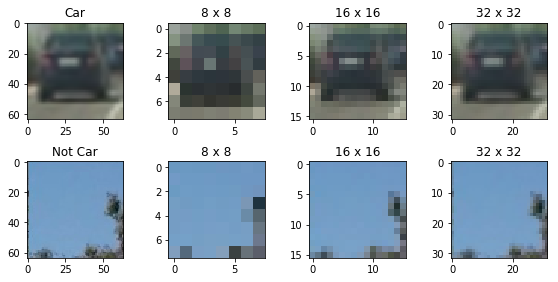

In [9]:
# Divide up into cars and notcars
images = glob.glob('./non-vehicles/*/*.png')
cars = []
notcars = []
for image in images[0:1]:
    notcars.append(image)
images = glob.glob('./vehicles/*/*.png')
for image in images[0:1]:
    cars.append(image)
        
sizes = [(8,8), (16,16), (32,32)]
for car, notcar in zip(cars, notcars):
    image = mpimg.imread(car)
    notcar_image = mpimg.imread(notcar)
    fig, axes = plt.subplots(2, 4, figsize=(8,4))
    axes[0,0].imshow(image)
    axes[0,0].set_title("Car")
    axes[1,0].imshow(notcar_image)
    axes[1,0].set_title("Not Car")
    for col, size in enumerate(sizes):
        car_bins = bin_spatial(image, size=size, feature_vec=False)
        notcar_bins = bin_spatial(notcar_image, size=size, feature_vec=False)
        axes[0, col+1].imshow(car_bins)
        axes[0, col+1].set_title("%d x %d" % (size[0], size[1]))
        axes[1, col+1].imshow(notcar_bins)
        axes[1, col+1].set_title("%d x %d" % (size[0], size[1]))
    fig.tight_layout()
    fig.savefig(OUTPUT_FOLDER +  "spatial_bining_comparision.png")
    

## Visualize histogram
Here we try out different color spaces and compare their histograms to see which color spaces and which channels show the most contrast.

Upon inspection, RGB, YUV and YCrCb appear to be good candidates. I decided to choose RGB for color_hist feature because matplotlib reads images in RGB by default, thus saving us an extra colour conversion step.

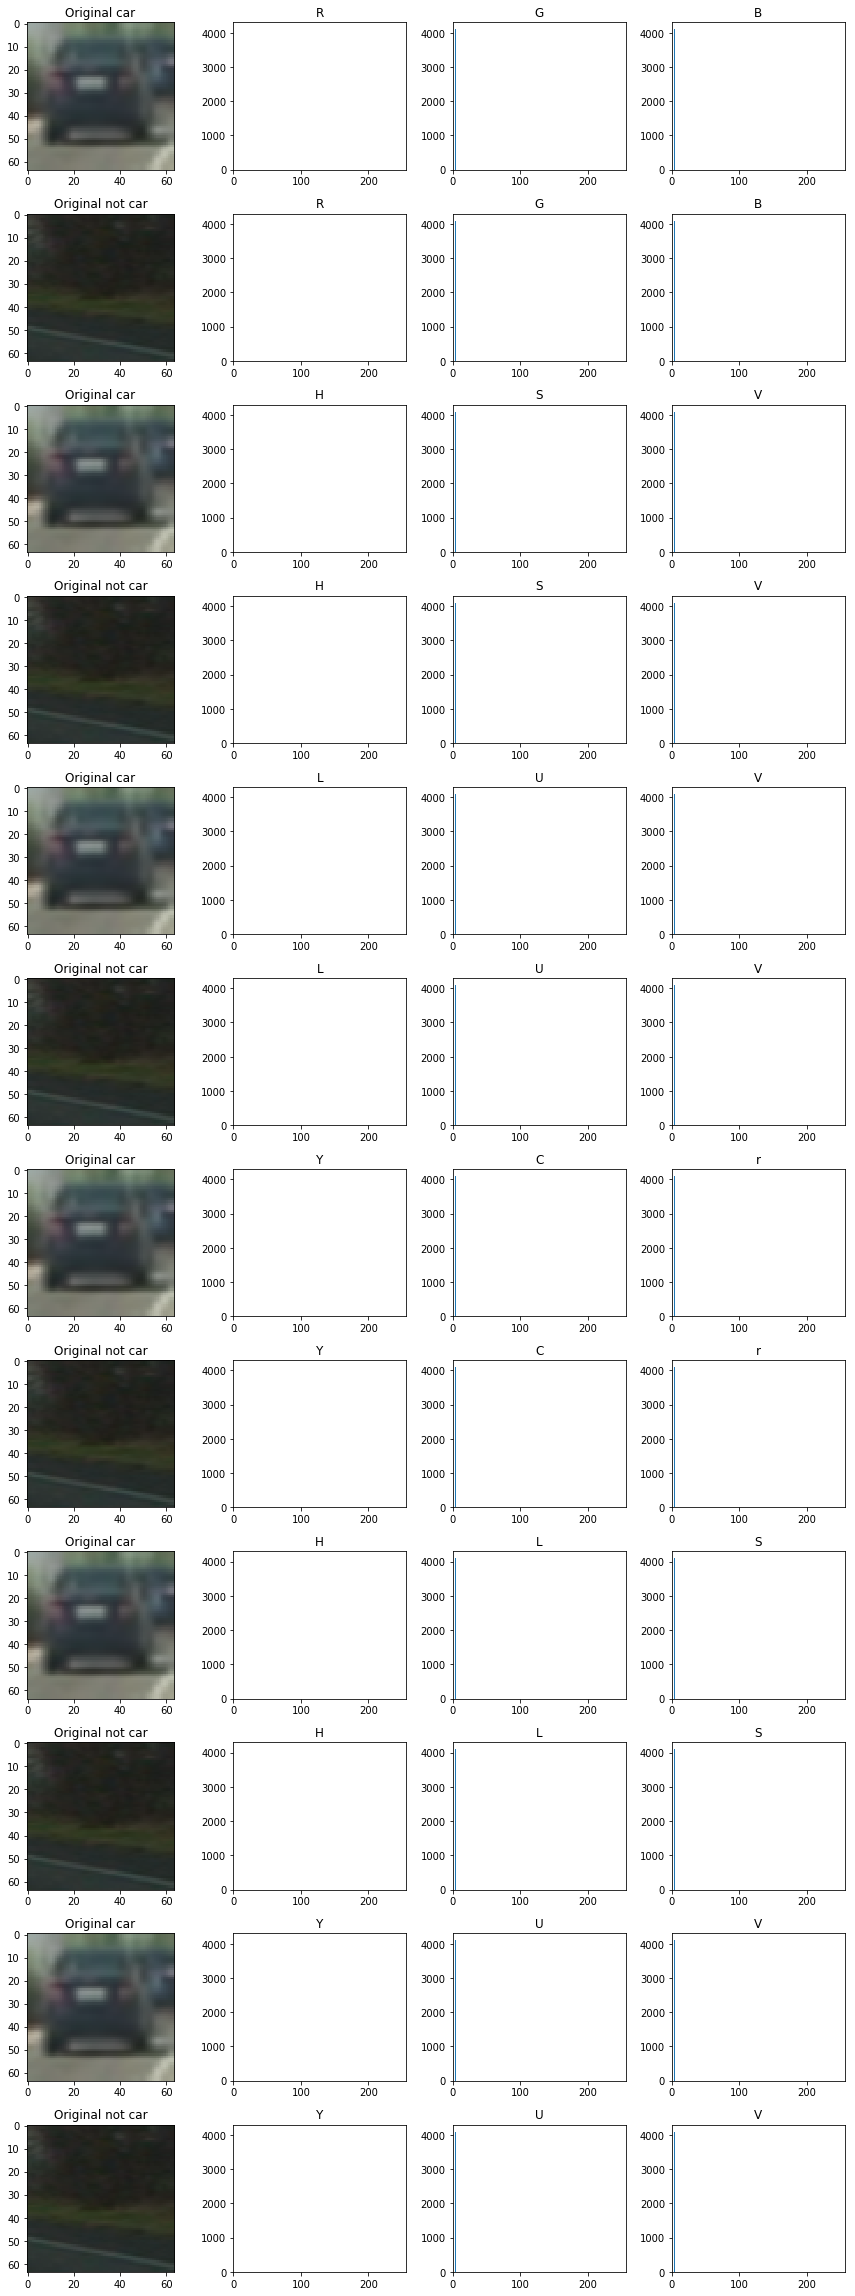

In [10]:
images = glob.glob('./non-vehicles/*/image3689.png')
cars = []
notcars = []
for image in images[0:1]:
        notcars.append(image)
images = glob.glob('./vehicles/*/*.png')
for image in images[0:1]:
        cars.append(image)

cspaces = ["RGB", "HSV", "LUV", "YCrCb", "HLS", "YUV"]
nbins = 32
for car_filename, notcar_filename in zip(cars, notcars):
    image = mpimg.imread(car_filename)
    notcar_image = mpimg.imread(notcar_filename)
    fig, axes = plt.subplots(12,4, figsize=(12,32))
    for row, cspace in enumerate(cspaces):
        feature_image = convert_color(image, cspace)
        notcar_feature_image = convert_color(notcar_image, cspace)
        feature_image = (feature_image * 255).astype(np.uint8)
        notcar_feature_image = (notcar_feature_image * 255).astype(np.uint8)
        axes[2*row,0].imshow(image)
        axes[2*row,0].set_title("Original car")
        axes[2*row+1,0].imshow(notcar_image)
        axes[2*row+1,0].set_title("Original not car")
        crh, cgh, cbh, cbincen, car_hist = color_hist(feature_image, nbins=nbins, bins_range=(0,256))
        rh, gh, bh, bincen, notcar_hist = color_hist(notcar_feature_image, nbins=nbins, bins_range=(0,256))
        axes[2*row, 1].bar(cbincen, crh[0])
        axes[2*row, 1].set_xlim(0, 256)
        axes[2*row, 1].set_title(cspace[0])
        axes[2*row, 2].bar(cbincen, cgh[0])
        axes[2*row, 2].set_xlim(0, 256)
        axes[2*row, 2].set_title(cspace[1])
        axes[2*row, 3].bar(cbincen, cbh[0])
        axes[2*row, 3].set_xlim(0, 256)
        axes[2*row, 3].set_title(cspace[2])
        axes[2*row+1, 1].bar(bincen, rh[0])
        axes[2*row+1, 1].set_xlim(0, 256)
        axes[2*row+1, 1].set_title(cspace[0])
        axes[2*row+1, 2].bar(bincen, gh[0])
        axes[2*row+1, 2].set_xlim(0, 256)
        axes[2*row+1, 2].set_title(cspace[1])
        axes[2*row+1, 3].bar(bincen, bh[0])
        axes[2*row+1, 3].set_xlim(0, 256)
        axes[2*row+1, 3].set_title(cspace[2])
    fig.tight_layout()
    fig.savefig(OUTPUT_FOLDER + "color_histogram_comparision.png")

## Visualize HOG
Here we try out different color spaces and compare their visualizations to see which color spaces and which channels show the most contrast and therefore, are the best to use for feature extraction. It was noticed later on that a lot of false positives were showing up and those are patches of road / guardrail that were in the shadows. Hence, we can use this function to chery pick non-car images that the SVM is getting wrong and figure out why.

Based on the plots below, it seems that S and V channel in the HSV colorspace provides the greatest contrast between car and non-car images.

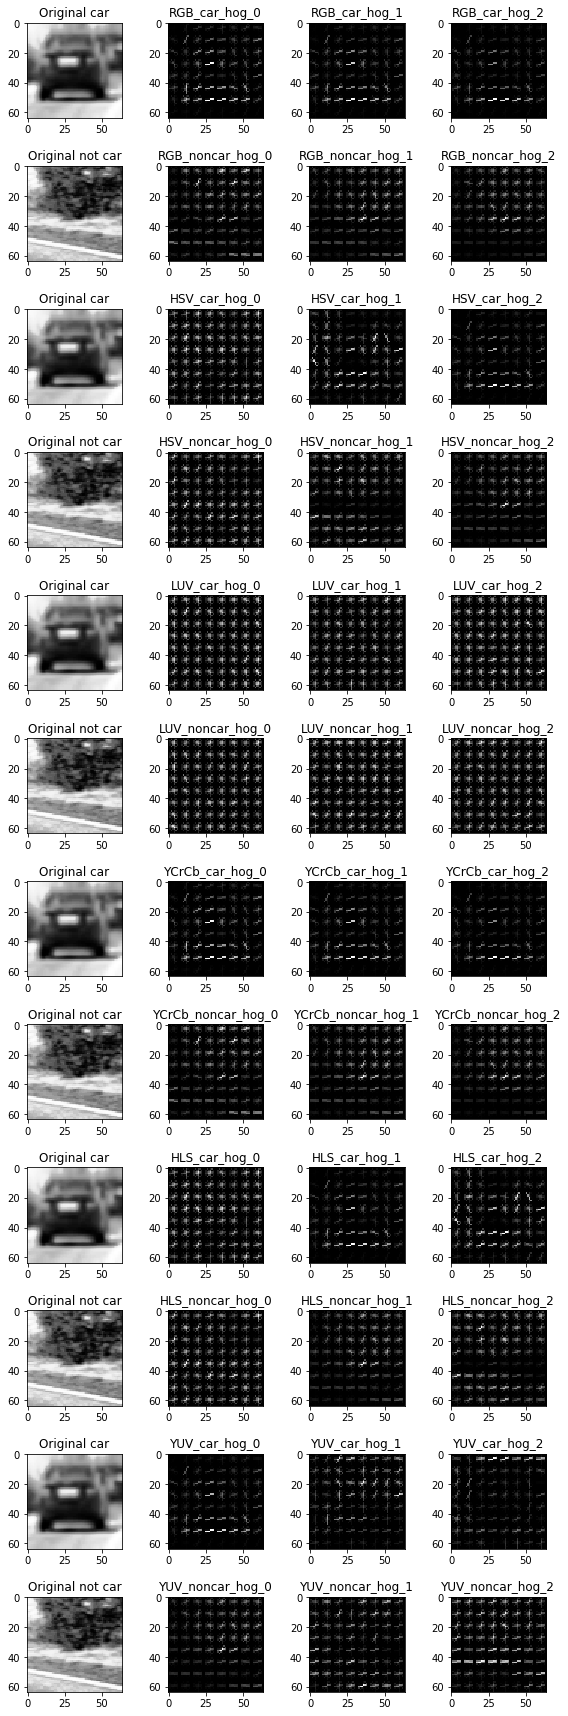

In [11]:
# Constants
colorspace = 'HSV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

images = glob.glob('./non-vehicles/*/image3689.png')
cars = []
notcars = []
for image in images[0:1]:
        notcars.append(image)
images = glob.glob('./vehicles/*/*.png')
for image in images[0:1]:
        cars.append(image)

cspaces = ["RGB", "HSV", "LUV", "YCrCb", "HLS", "YUV"]
for car_filename, notcar_filename in zip(cars, notcars):
    image = mpimg.imread(car_filename)
    notcar_image = mpimg.imread(notcar_filename)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray = equalize_hist(gray)
    notcar_gray = cv2.cvtColor(notcar_image, cv2.COLOR_RGB2GRAY)
    notcar_gray = equalize_hist(notcar_gray)
    fig, axes = plt.subplots(12,4, figsize=(8,24))
    for row, cspace in enumerate(cspaces):
        feature_image = convert_color(image, cspace)
        notcar_feature_image = convert_color(notcar_image, cspace)
        axes[2*row,0].imshow(gray, cmap='gray')
        axes[2*row,0].set_title("Original car")
        axes[2*row+1,0].imshow(notcar_gray, cmap='gray')
        axes[2*row+1,0].set_title("Original not car")
        for channel in range(feature_image.shape[2]):
            feature_equalized = equalize_hist(feature_image[:,:,channel])
            features, hog_image = get_hog_features(feature_equalized, 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=True, feature_vec=True)
            axes[2*row,channel+1].imshow(hog_image, cmap='gray')
            axes[2*row,channel+1].set_title(cspace + "_car_hog_%d" % channel)
        for channel in range(feature_image.shape[2]):
            notcar_feature_equalized = equalize_hist(notcar_feature_image[:,:,channel])
            features, hog_image = get_hog_features(notcar_feature_equalized, 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=True, feature_vec=True)
            axes[2*row+1,channel+1].imshow(hog_image, cmap='gray')
            axes[2*row+1,channel+1].set_title(cspace + "_noncar_hog_%d" % channel)
        fig.tight_layout()
    fig.savefig(OUTPUT_FOLDER + "hog_colorspace_comparision.png")

## Train the classifer using SVM

In [ ]:
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
import time

# Divide up into cars and notcars
images = glob.glob('./non-vehicles/*/*.png')
cars = []
notcars = []
for image in images:
        notcars.append(image)
images = glob.glob('./vehicles/*/*.png')
for image in images:
        cars.append(image)

# Reduce the sample size because HOG features are slow to compute
sample_size = 8000
cars = cars[0:sample_size]
notcars = notcars[0:sample_size]

### TODO: Tweak these parameters and see how the results change.
augmentation_factor = 3 # extra images to add per training data such that final dataset size = augmentation_factor * sample_size
spatial_size = (16,16)
hist_bins = 32
colorspace = 'HSV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb, to be used for HOG
hist_colorspace = 'RGB' # colorspace to be used for histogram of colors
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

t=time.time()
car_features = extract_features(cars, hist_colorspace=hist_colorspace, cspace=colorspace, spatial_size=spatial_size,
                        hist_bins=32, hist_range=(0,256), orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, augmentation_factor=augmentation_factor)
notcar_features = extract_features(notcars, hist_colorspace=hist_colorspace, cspace=colorspace, spatial_size=spatial_size,
                        hist_bins=32, hist_range=(0,256), orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, augmentation_factor=augmentation_factor)

print("Training with %d features on %d positive-datapoints and %d negative datapoints" % (car_features[0].shape[0], len(car_features), len(notcar_features)))

t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

In [ ]:
from sklearn.svm import SVC
from sklearn import grid_search
import pickle

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)

# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

t=time.time()

# Grid search the best model
parameters = {'kernel':('linear', 'rbf'), 'C':[0.1, 1]}
svr = SVC()
svc = grid_search.GridSearchCV(svr, parameters)
svc.fit(X_train, y_train)

# Check the training time for the SVC
# svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to find best parameters and train SVC...')
# Check the score of the SVC
print('Best Train Accuracy of SVC = ', round(svc.score(X_train, y_train), 4))
print('Best Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
best_params = svc.best_params_
print('Best parameters for SVC: ' + str(best_params))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

# Save the model
with open("svc_trained_%d_samples" % sample_size, 'wb') as f:
    pickle.dump(svc, f)

## Sliding windows

In [ ]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, window, ystart, ystop, scale, hist_cspace, cspace, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    bboxes = []
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, cspace)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    # Equalize histogram - although equalizing per window would give the best results, that would be too slow
    # Hence we only equalize the entire patch of the image that is bounded by the road.
    ch1 = equalize_hist(ch1)
    ch2 = equalize_hist(ch2)
    ch3 = equalize_hist(ch3)
    ctrans_tosearch_equalized = cv2.merge((ch1, ch2, ch3))

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    # window is now a variable, to support multi-scale windows
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    # print(nblocks_per_window, cell_per_block, nxsteps, nysteps)
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch_equalized[ytop:ytop+window, xleft:xleft+window], (64,64))
            
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            _, _, _, _, hist_features = color_hist(subimg, cspace=hist_cspace, nbins=hist_bins)
#             print(spatial_features.shape, hist_features.shape, hog_features.shape)
            
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
#             test_features = X_scaler.transform(hog_features.reshape(1, -1))
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                # print(svc.decision_function(test_features))
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                top_left = (xbox_left, ytop_draw+ystart)
                bottom_right = (xbox_left+win_draw,ytop_draw+win_draw+ystart)
                bboxes.append((top_left, bottom_right))
                cv2.rectangle(draw_img, top_left, bottom_right,(0,0,255),6) 
                
    return draw_img, bboxes


In [ ]:
import os

small_window = 32
small_ystart = 400
small_ystop = 520
small_pix_per_cell = 4

med_window = 64
med_ystart = 400
med_ystop = 680
med_pix_per_cell = 8

large_window = 96
large_ystart = 480
large_ystop = 700
large_pix_per_cell = 12

scale = 1.5


start = time.time()
images = glob.glob(TEST_FOLDER + "*.jpg")
fig, axes = plt.subplots(len(images), 3, figsize=(6*3, 2*len(images)))
for row, filename in enumerate(images):
    img = mpimg.imread(filename)
    out1_img, small_bboxes = find_cars(img, small_window, small_ystart, small_ystop, scale, hist_colorspace, colorspace, svc, X_scaler, orient, small_pix_per_cell, cell_per_block, spatial_size, hist_bins)
    out2_img, medium_bboxes = find_cars(img, med_window, med_ystart, med_ystop, scale, hist_colorspace, colorspace, svc, X_scaler, orient, med_pix_per_cell, cell_per_block, spatial_size, hist_bins)
    out3_img, large_bboxes = find_cars(img, large_window, large_ystart, large_ystop, scale, hist_colorspace, colorspace, svc, X_scaler, orient, large_pix_per_cell, cell_per_block, spatial_size, hist_bins)
    axes[row, 0].imshow(out1_img)
    axes[row, 1].imshow(out2_img)
    axes[row, 2].imshow(out3_img)
    plt.imsave(OUTPUT_FOLDER + "sliding_small_windows_" + filename.split(os.path.sep)[-1], out1_img)
    plt.imsave(OUTPUT_FOLDER + "sliding_medium_windows_" + filename.split(os.path.sep)[-1], out2_img)
    plt.imsave(OUTPUT_FOLDER + "sliding_large_windows_" + filename.split(os.path.sep)[-1], out3_img)
end = time.time() - start
print("%.2fs taken for %d images" % (end, len(images)))

## Heatmap
1. Draw a heatmap based on list of detections
2. Apply a threshold to remove false positives
3. Draw bounding boxes on the final detected cars

In [ ]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

from scipy.ndimage.measurements import label

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

images = glob.glob(TEST_FOLDER + "*.jpg")
for filename in images:
    img = mpimg.imread(filename)
    out_img, bboxes = find_cars(img, ystart, ystop, scale, hist_colorspace, colorspace, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat, bboxes)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,3)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    plt.imsave(OUTPUT_FOLDER + "heatmap_" + filename.split(os.path.sep)[-1], heatmap)
    
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    final_img = draw_labeled_bboxes(np.copy(img), labels)
    plt.figure()
    plt.imshow(final_img)
    plt.imsave(OUTPUT_FOLDER + "final_detected_cars_" + filename.split(os.path.sep)[-1], final_img)